# Restricted Boltzmann machine

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from scipy.special import expit

In [2]:
# set random seed
np.random.seed(12345)

## Load data

In [3]:
# decide between binary and [0, 1]-valued data
IS_BINARY = True

In [4]:
# load data
x, _ = load_digits(return_X_y=True)

x = x.astype(np.float32)
x = x / 16.0  # scale data into interval [0, 1]

if IS_BINARY:
    x = np.where(x < 0.5, 0, 1)  # make binary data in {0, 1}

print(f'Data shape: {x.shape}')
print(
    f'Values in: {set(np.unique(x))}' if IS_BINARY
    else f'Values in: [{x.min()}, {x.max()}]'
)

Data shape: (1797, 64)
Values in: {np.int64(0), np.int64(1)}


In [5]:
# split into train and test set
x_train, x_test = train_test_split(x, test_size=0.2)

print(f'Number of train samples: {len(x_train)}')
print(f'Number of test samples: {len(x_test)}')

Number of train samples: 1437
Number of test samples: 360


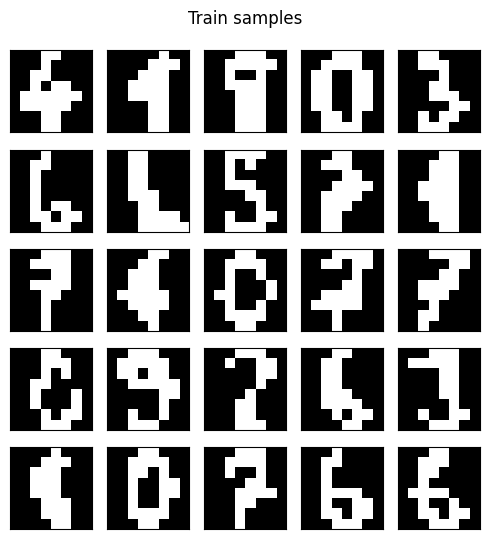

In [6]:
# plot train samples
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5.5))
random_train_ids = np.random.choice(len(x_train), size=axes.size, replace=False)
for idx, ax in enumerate(axes.ravel()):
    image = x_train[random_train_ids[idx]].reshape(8, 8)
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.suptitle('Train samples')
fig.tight_layout()

## Train RBM

In [7]:
# train RBM
rbm = BernoulliRBM(
    n_components=16,
    learning_rate=0.1,
    batch_size=10,
    n_iter=40,
    verbose=True
)

rbm.fit(x_train)

print(f'Weight matrix shape: {rbm.components_.shape}')  # (num_hidden, num_visible)
print(f'Bias shape (hidden): {rbm.intercept_hidden_.shape}')  # (num_hidden,)
print(f'Bias shape (visible): {rbm.intercept_visible_.shape}')  # (num_visible,)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -27.51, time = 0.01s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -25.70, time = 0.01s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.02, time = 0.01s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.67, time = 0.01s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -20.63, time = 0.01s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -19.39, time = 0.01s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.27, time = 0.01s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -19.49, time = 0.01s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -19.87, time = 0.01s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -18.58, time = 0.01s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -17.91, time = 0.01s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.00, time = 0.01s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -15.63, time = 0.01s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -18.13, time = 0.01s
[BernoulliRBM] Iteration 15, 

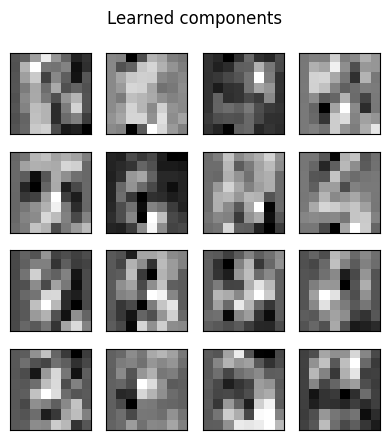

In [8]:
# plot learned components
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(4, 4.5))
for idx, ax in enumerate(axes.ravel()):
    image = rbm.components_[idx].reshape(8, 8)
    ax.imshow(image, cmap='gray')
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.suptitle('Learned components')
fig.tight_layout()

## Compute hidden representations

In [9]:
# compute hidden unit activation probability p(h=1|v) = E[h|v]
z_train = rbm.transform(x_train)
z_test = rbm.transform(x_test)

print(f'Hidden shape (train): {z_train.shape}')
print(f'Hidden shape (test): {z_test.shape}')

Hidden shape (train): (1437, 16)
Hidden shape (test): (360, 16)


In [10]:
# sample hidden units h_i
def sample_hidden(rbm, v):
    '''Sample hidden units according to p(h|v).'''
    p = rbm.transform(v)
    return np.random.uniform(size=p.shape) < p  # get binary sample

z_train_sample = sample_hidden(rbm, x_train)
z_test_sample = sample_hidden(rbm, x_test)

print(f'Hidden shape (train): {z_train_sample.shape}')
print(f'Hidden shape (test): {z_test_sample.shape}')

Hidden shape (train): (1437, 16)
Hidden shape (test): (360, 16)


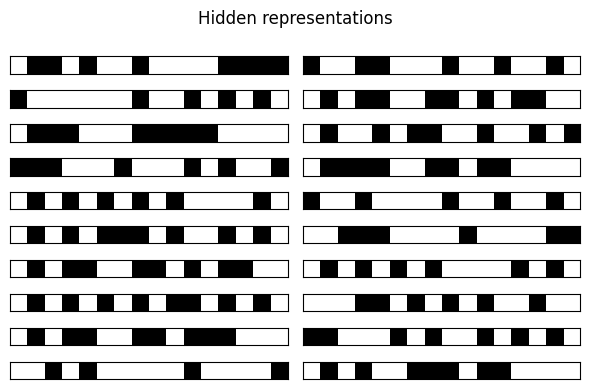

In [11]:
# plot hidden units
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(6, 4))
for idx, ax in enumerate(axes.ravel()):
    image = z_train_sample[random_train_ids[idx]].reshape(1, -1)
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')
fig.suptitle('Hidden representations')
fig.tight_layout()

## Compute reconstructions

In [12]:
# compute visible unit activation probability p(v=1|h) = E[v|h]
def rbm_inverse_transform(rbm, h):
    '''Compute p(v=1|h) for a given vector of hidden units.'''
    return expit(np.dot(h, rbm.components_) + rbm.intercept_visible_)  # see docstring of `BernoulliRBM._sample_visibles`

x_train_recon = rbm_inverse_transform(rbm, z_train)
x_test_recon = rbm_inverse_transform(rbm, z_test)

print(f'Reconstructed shape (train): {x_train_recon.shape}')
print(f'Reconstructed shape (test): {x_test_recon.shape}')

Reconstructed shape (train): (1437, 64)
Reconstructed shape (test): (360, 64)


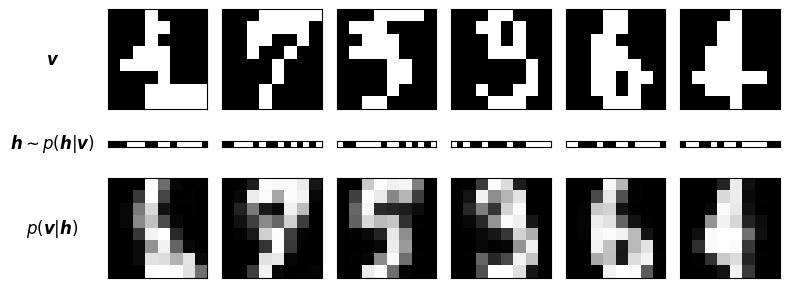

In [13]:
# plot visible units
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(8, 3))
random_test_ids = np.random.choice(len(x_test_recon), size=axes.shape[1], replace=False)

for idx, ax in enumerate(axes[0]):
    image = x_test[random_test_ids[idx]].reshape(8, 8)
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')

for idx, ax in enumerate(axes[1]):
    image = z_test_sample[random_test_ids[idx]].reshape(1, -1)
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')

for idx, ax in enumerate(axes[2]):
    image = x_test_recon[random_test_ids[idx]].reshape(8, 8)
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.set(xticks=[], yticks=[], xlabel='', ylabel='')

axes[0, 0].set_ylabel('$\\boldsymbol{v}$', fontsize=12, rotation=0, labelpad=40, va='center')
axes[1, 0].set_ylabel('$\\boldsymbol{h} \\sim p(\\boldsymbol{h} | \\boldsymbol{v})$', fontsize=12, rotation=0, labelpad=40, va='center')
axes[2, 0].set_ylabel('$p(\\boldsymbol{v} | \\boldsymbol{h})$', fontsize=12, rotation=0, labelpad=40, va='center')

fig.tight_layout()